In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'W':
          y = np.array([1,0,0,0,0])
        elif y == '1':
          y = np.array([0,1,0,0,0])
        elif y == '2':
          y = np.array([0,0,1,0,0])   
        elif y == '3':
          y = np.array([0,0,0,1,0])
        elif y == '4':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
          
    def __len__(self):
        return self.data_adress[-1]


In [4]:
class MASS_dataset(Dataset):
    def __init__(self, files):
        self.files = files
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        

        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 1, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 1, keepdims=True) # shape = c,t
        c,t = data.shape
        
        return data/data_max*np.ones((c,t)) - (data_max - data_min)*np.ones((c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):          
        sample = np.load(self.files[index])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.preprocessing(sample['x'])
        return { 'x' : torch.tensor(sample), 
                 'y' : torch.tensor(y)
                   }
          
    def __len__(self):
        return len(self.files)

In [5]:
import glob

SS1_list = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEG/17channels/**')
print(len(SS1_list))
MASS_list = []
for i in range(len(SS1_list)):
    MASS_list.extend(glob.glob(SS1_list[i]+'/**'))
print(len(MASS_list))

5
4683


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(MASS_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
train, val = train_test_split(train, test_size= 0.25)#, shu

In [7]:
train_dataset = MASS_dataset(train)
val_dataset = MASS_dataset(val)
test_dataset = MASS_dataset(test)

In [8]:
!pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import numpy as np
import torch
import torch.nn as nn
from mne.filter import filter_data, notch_filter
import matplotlib.pyplot as plt
class Encoder(nn.Module):
    def __init__(self, fs, encode_info):
        super(Encoder, self).__init__()
        #spectral layer means spectral convolution
        #self.bac_layer is consist of several SeparableConv2d, which plays the role of temporal separable convolution
        #convolution layer are initiated by xavier_uniform initization
        #Input are Normalized by self.bn(=torch.nn.BatchNorm2d)
        #[batch, electrode, length] -> [batch, electrode, Feature]
        self.fs = fs
        self.elu = nn.ELU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(1)
        self.activation = nn.LeakyReLU()

        self.spectral_layer = nn.Conv1d(1, 10, int(self.fs/2), padding="same")

        # self.bac_layer = nn.Sequential()
        # for i, arg in enumerate(encode_info):
        #     input_dim, output_dim, kernel_size = arg
        #     self.bac_layer.add_module("temporal_conv_"+str(i),
        #                           nn.Conv1d(input_dim, output_dim, kernel_size, padding = 'same'))
        #     self.bac_layer.add_module("ELU",nn.ELU()) 
        
        self.conv1t = nn.Conv1d(10,16, 30, padding ='same')
        self.conv2t = nn.Conv1d(16,32, 15, padding ='same')
        self.conv3t = nn.Conv1d(32,64, 5, padding ='same')
        
        # torch.nn.init.xavier_uniform_(self.spectral_layer.weight)
        #self.bac_layer.apply(weight_init_xavier_uniform)

    def forward(self, x):
        x = self.activation(self.spectral_layer(x))
        x = self.activation(self.conv1t(x))
        x = self.activation(self.conv2t(x))
        x = self.activation(self.conv3t(x))

        return x

#Linear layer for SSL classification
class Head_NN(nn.Module):
    def __init__(self, length):
        super(Head_NN, self).__init__()
        self.length = length
        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 5)
        )
        self.softmax = torch.nn.Softmax()
        # self.layer.apply(weight_init_xavier_uniform)
        self.bn = nn.BatchNorm1d(64)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = torch.mean(x, axis = 2) # Global average pooling into temporal dimension
        x = self.layer(x)
        x = self.softmax(x)
        return x

class StoppedBandPathway(nn.Module):
    def __init__(self, fs, Unsupervise, encode_info, bands):
        super(StoppedBandPathway, self).__init__()
        self.encoder = Encoder(fs, encode_info)
        self.pretrain = Head_NN(2000)
        self.Unsupervise = Unsupervise


    def forward(self, x):
        x = self.encoder(x)
        x = self.pretrain(x)
        return x

    def getRep(self, x):
        x = self.encoder(x)
        return x


In [10]:

class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Activation functions
        self.activation = nn.LeakyReLU()
        # self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nn.Conv1d(1,10, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(10,10,self.channels)
        self.conv2t = nn.Conv1d(10,20,15,padding ='same') 
        self.conv2s = nn.Conv1d(20,20,self.channels)
        self.conv3t = nn.Conv1d(20,34,5,padding ='same')
        self.conv3s = nn.Conv1d(34,34,self.channels)
        
                  
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(256000 ,4) # 

      
    def embedding(self, x):
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1 )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

In [11]:
class SpatialNetwork(nn.Module):
    def __init__(self,temporal_len):
        super(SpatialNetwork, self).__init__()

        # input length/2 = output of conv1 length
        # self.conv1 = nn.Conv1d(1, 16, stride = 2 ,padding = 14, kernel_size=30) 
        self.conv1 = nn.Conv1d(1, 16, padding = "same", kernel_size=30) 
        self.conv2 = nn.Conv1d(16, 32, padding="same", kernel_size=15)
        self.conv3 = nn.Conv1d(32, 64, padding="same", kernel_size=5)


        self.Spatial_conv_17 = nn.Conv2d(64,64,kernel_size = (17,1)) 
        self.maxpool = nn.MaxPool2d(3, stride=2)


        self.dropout = nn.Dropout(0.5)

        # self.fc = nn.Linear(FL[-1] * 2, 5)
        self.fc = nn.Linear(3069, 5)
        self.elu = nn.ELU()
        self.classifier = nn.Softmax(dim=1)
        self.softmax = nn.Softmax()
        self.flatten = nn.Flatten()

        # xavier initialization
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)

    def embedding1(self, x, b, c):
        # X=(B,C,T)

        # X=(B*C,1,T)
        x = self.elu(self.conv1(x))

        # X=(B*C,F,T2)
        x = self.elu(self.conv2(x))

        # X=(B*C,F,T3)
        x = self.elu(self.conv3(x))
        
        bc,f,t = x.shape 
        x = torch.reshape(x,(b,c,f,t))
        
        # X=(B,F,T4*2) # remove summation part, because each of dataset has a different number of channels
        # x = torch.cat([x.max(dim=1)[0], x.sum(dim=1) / c], dim=1)       
        return x

    def embedding2(self, x, b, c):
        x = self.embedding1(x,b,c)
        b,c,f,t = x.shape
        x = torch.reshape(x,(b,f,c,t))
        if c == 17:
          x = self.elu(self.Spatial_conv_17(x))
          # print(x.shape) # b,64,1,t
          # x = torch.squeeze(x)
          # x = self.maxpool(x)
             
        return x    

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        # feature = torch.mean(feature, dim = 2) 
        feature = self.flatten(feature)
        ## feature.shape = [batch,filter]

        feature = self.dropout(feature)
        y_hat = self.softmax(self.fc(feature))
        return y_hat   
    
    def forward(self,x,b,c):
        # print('1:',out.shape)
        x = self.embedding2(x,b,c)
        x = self.classifier(x)
        return x



In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class StatisticianModule(nn.Module):
    def __init__(self, dense, classes):
        super(StatisticianModule, self).__init__()
        self.classes = classes
        
        self.conv1 = nn.Conv2d(64,64, (17,1))
        self.conv2 = nn.Conv2d(64,64, (17,1))   
        self.conv2 = nn.Conv2d(31,31, (17,1))


        self.softmax = torch.nn.Softmax(dim=1)
        self.c_dense = nn.Linear(dense, 64*2*3) # 64*2*2

        self.gap_pwconv = nn.Conv1d(192, dense, 1) 
        self.gvp_pwconv = nn.Conv1d(192, dense, 1)

        self.fullconnect = nn.Linear(dense, self.classes)

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.c_dense.weight)
        torch.nn.init.xavier_uniform_(self.gap_pwconv.weight)
        torch.nn.init.xavier_uniform_(self.gvp_pwconv.weight)
        torch.nn.init.xavier_uniform_(self.fullconnect.weight)
        

    def GAPGVP(self, x1, x2,x3, b,c,f,t ):
        x1 = torch.reshape(x1,(b,f,c,t)) 
        x2 = torch.reshape(x2,(b,f,c,t)) 
        x3 = torch.reshape(x3,(b,f,c,t)) 

        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        x3 = self.conv3(x3)
        # print('x1',x1.shape)
        # print('x2',x2.shape)
        # print('x3',x3.shape)

        f_GAP = torch.cat((F.adaptive_avg_pool2d(x1, (1, 1)).squeeze(), F.adaptive_avg_pool2d(x2, (1, 1)).squeeze() ,F.adaptive_avg_pool2d(x3, (1, 1)).squeeze()), axis=1)
        # print('f_GAP',f_GAP.shape)

        f_GVP = torch.cat((torch.var(x1.view(x1.size(0), x1.size(1), -1), dim=2),torch.var(x2.view(x2.size(0), x2.size(1), -1), dim=2), torch.var(x3.view(x3.size(0), x3.size(1), -1), dim=2)),axis=1)
        # print('f_GVP',f_GVP.shape)

        del x1
        del x2
        del x3
        return f_GAP, f_GVP

    def forward(self,x1, x2,x3, b,c,f,t):
        f_GAP, f_GVP = self.GAPGVP(x1, x2, x3, b,c,f,t )
        # print(f_GAP.shape, f_GVP.shape)
        c = self.softmax(self.c_dense(torch.cat((f_GAP, f_GVP),axis=1)))
        # print('c:',c.shape)
        #[batch, gap, 1] -> [batch, 1, dense] -> [batch, dense]
        f_GAP_d = self.gap_pwconv(f_GAP.unsqueeze(dim=-1)).squeeze()
        f_GVP_d = self.gvp_pwconv(f_GVP.unsqueeze(dim=-1)).squeeze()
        
        f_GAP_dd = torch.sum(c*f_GAP_d,dim=1)
        f_GVP_dd = torch.sum(c*f_GVP_d,dim=1)
        # print('f_GAP_dd: ',f_GAP_dd.shape)
        ALN = torch.div(torch.sub(f_GAP_d.T,f_GAP_dd),f_GAP_dd).T
        # print('ALN', ALN.shape)

        y_hat = self.fullconnect(ALN)
        # print('y_hat: ',y_hat.shape)
        return y_hat

load pretrain model

In [13]:
FE1 = torch.load('/content/Spectral__10s_ep6_.pt')
FE2 = torch.load('/content/Spike_10s_ep8_.pt')
FE3 = torch.load('/content/Temporal__10s_ep15_.pt')

FE1.eval()
FE2.eval()
FE3.eval()

feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=None)
  (conv1t): Conv1d(1, 10, kernel_size=(30,), stride=(1,), padding=same)
  (conv1s): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
  (conv2t): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=same)
  (conv2s): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (conv3t): Conv1d(20, 34, kernel_size=(5,), stride=(1,), padding=same)
  (conv3s): Conv1d(34, 34, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (Linear): Linear(in_features=128000, out_features=4, bias=True)
)

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

print(device)


cuda:0


In [15]:
epochs = 30
learning_rate = 0.0005
batch_size = 10
model = StatisticianModule(384,5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
from torch.utils.data import DataLoader


trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)


In [ ]:
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding1(data,b,c) 
        x3 =  FE3.embedding(data)
        del data
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,x3,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding1(data,b,c) 
        x3 =  FE3.embedding(data)
        del data

        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,x3,b,c,f,t)
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)

       
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'MASS_10s_ep' + str(epoch)+'_.pt')


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('MASS_10s.xlsx', index = False)

In [ ]:
epochs = 19

In [ ]:
import matplotlib.pyplot as plt
  
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('MASS_10s_loss.png',bbox_inches = 'tight')
plt.show() 

In [ ]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('MASS_10s_accuracy.png',bbox_inches = 'tight')
plt.show()

In [18]:
model = torch.load('/content/MASS_10s_ep15_.pt').to(device)

In [19]:
loss_ep_test = 0
acc_ep_test = 0
for batch_idx, batch in enumerate(testLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding1(data,b,c) 
        x3 =  FE3.embedding(data)
        del data
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,x3,b,c,f,t)
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)

       
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_test += loss.item()
        acc_ep_test += acc

acc_ep_test = acc_ep_test/len(testLoader)
loss_ep_test = loss_ep_test/len(testLoader)

print(acc_ep_test)
print(loss_ep_test)

0.5682370820668693
1.0883751597372946


In [20]:
label_list = []
predicted_list = []
for batch_idx, batch in enumerate(testLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding1(data,b,c) 
        x3 =  FE3.embedding(data)
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,x3,b,c,f,t)
        label = batch['y'].type(torch.float64).to(device)
               
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        label_list.extend(label.cpu().detach().numpy())
        predicted_list.extend(predicted.cpu().detach().numpy())

In [21]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(label_list, predicted_list)
print(conf_matrix)

[[144   3  60   0  19]
 [ 51   6  69   0   7]
 [ 37   9 350   1   7]
 [  0   0  54   7   0]
 [ 24   3  61   0  25]]


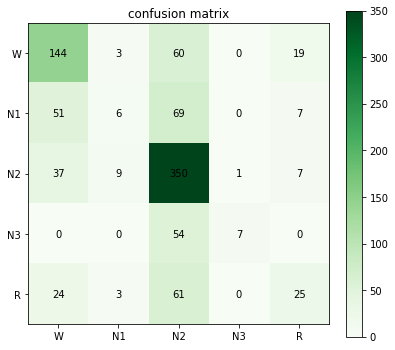

In [22]:
title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(5, 5)
plt.yticks(np.arange(5), ('W','N1','N2','N3','R'))
plt.xticks(np.arange(5), ('W','N1','N2','N3','R'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment
plt.savefig('MASS1_10s_confusion matrix.png',bbox_inches = 'tight')